<a href="https://colab.research.google.com/github/serg-kas/Seams-segm/blob/master/Model_Unet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Seams semantic segmentation

### Подготовка окружения

In [1]:
!git clone https://github.com/serg-kas/Seams-segm
%cd Seams-segm
!ls

Cloning into 'Seams-segm'...
remote: Enumerating objects: 518, done.
remote: Counting objects: 100% (137/137), done.
remote: Compressing objects: 100% (128/128), done.
remote: Total 518 (delta 28), reused 108 (delta 9), pack-reused 381
Receiving objects: 100% (518/518), 120.60 MiB | 17.48 MiB/s, done.
Resolving deltas: 100% (83/83), done.
/content/Seams-segm
imgs  masks  Model_Unet.ipynb  prep_data.py  README.md	unet.py  utils.py


In [2]:
# Подключим google disk
from google.colab import drive 
drive.mount('/content/drive')

# Путь к папке с данным
PATH = '/content/drive/MyDrive/my_data/Seams-segm/'

!ls {PATH}

Mounted at /content/drive
00-Unet  00-Unet.h5


In [3]:
# Импорт библиотек
import numpy as np
import math
import cv2 as cv
import random
import os
import time
#
import utils as u 
import unet
#
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import Model 
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout, BatchNormalization
from tensorflow.keras.layers import Input, Conv2DTranspose, concatenate, Activation, MaxPooling2D, Conv2D
from tensorflow.keras.layers import Reshape, GlobalAveragePooling2D, UpSampling2D, AveragePooling2D
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
from tensorflow.keras import backend as K        
from keras.callbacks import ReduceLROnPlateau, EarlyStopping 
from tensorflow.keras.utils import Sequence
from tensorflow.keras.models import load_model, save_model
from tensorflow.keras.utils import plot_model
#
import albumentations as A
#
from google.colab.patches import cv2_imshow
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
# Пути к данным
images_path = "/content/Seams-segm/imgs"
anns_path = "/content/Seams-segm/masks"

In [5]:
# Создадим списки файлов с путями к ним
img_names= [ os.path.join(images_path, file_name) for file_name in os.listdir(images_path)]
ann_names = [ os.path.join(anns_path, file_name) for file_name in os.listdir(anns_path)]

In [6]:
# Посмотрим каких размеров картинки в датасете
dict = {}
cur_time = time.time()
for file_name  in img_names:
    img = cv.imread(file_name)
    if str(img.shape) in dict.keys():
        dict[str(img.shape)] += 1
    else:
        dict[str(img.shape)] = 1
    
print("Имеем картинок: {}".format(len(img_names)))
print("Встречаются размеры: {}".format(dict))
print("Время выполнения: ", round(time.time() - cur_time, 2), 'c', sep='')

Имеем картинок: 41
Встречаются размеры: {'(1024, 1024, 3)': 15, '(1024, 915, 3)': 1, '(964, 1024, 3)': 1, '(767, 1024, 3)': 1, '(1024, 1022, 3)': 1, '(896, 1024, 3)': 1, '(1024, 864, 3)': 1, '(744, 1024, 3)': 1, '(714, 1024, 3)': 1, '(905, 1024, 3)': 1, '(892, 1024, 3)': 1, '(1024, 816, 3)': 1, '(706, 1024, 3)': 1, '(958, 1024, 3)': 1, '(1024, 665, 3)': 1, '(770, 1023, 3)': 1, '(987, 1024, 3)': 1, '(925, 1024, 3)': 2, '(1024, 831, 3)': 1, '(1024, 1013, 3)': 1, '(989, 1024, 3)': 1, '(501, 1024, 3)': 1, '(1024, 953, 3)': 1, '(1024, 929, 3)': 1, '(907, 1024, 3)': 1, '(466, 1023, 3)': 1}
Время выполнения: 1.07c


In [6]:
# Соберем информацию о классах разметки сегментации
ann_set = np.array([])
cur_time = time.time()
for file_name  in ann_names:
    ann = cv.imread(file_name,0)
    # print(ann.shape)
    curr_set = np.unique(ann)
    ann_set = np.union1d(ann_set, curr_set)
    
print("Получили классы разметки: {}".format(ann_set))
print("Время выполнения: ", round(time.time() - cur_time, 2), 'c', sep='')

Получили классы разметки: [  0. 255.]
Время выполнения: 0.69c


In [7]:
# Классы сегментации
# 0 - швы
# 255 - плитка (кирпич, доска)
classes = [0, 255]

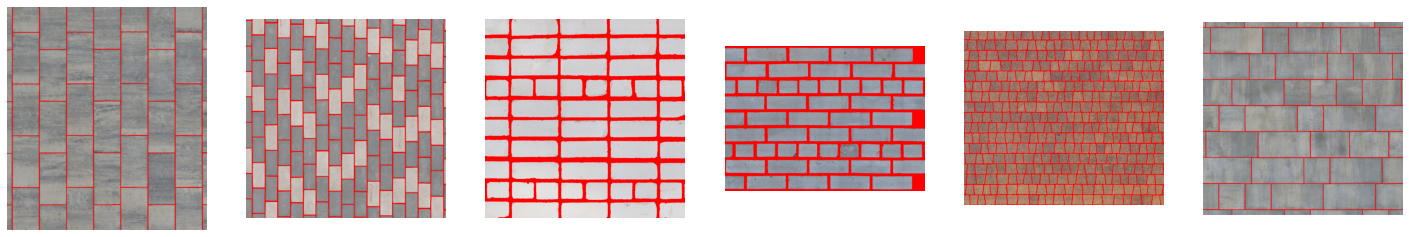

In [8]:
# Посмотрим несколько случайных картинок из тренировочной выборки.
# Швы из разметки выделим КРАСНЫМ цветом.
n = 6
fig, axs = plt.subplots(1, n, figsize=(25, 10))  

n_files = random.choices(img_names, k=n) 

for i,file in enumerate(n_files):                               
  image = cv.imread(file)
  image = cv.cvtColor(image, cv.COLOR_BGR2RGB)
  ann = cv.imread(os.path.join(anns_path, os.path.basename(file)), 0) 
    
  ones = np.ones((ann.shape[0], ann.shape[1], 3),dtype = np.uint8)
  
  image[:, :, 0] = np.where(ann == 255, image[:, :, 0], ones[:, :, 0] * 255)
  image[:, :, 1] = np.where(ann == 255, image[:, :, 1], ones[:, :, 0] * 0)
  image[:, :, 2] = np.where(ann == 255, image[:, :, 2], ones[:, :, 0] * 0)

  axs[i].axis('off')
  axs[i].imshow(image)             

plt.show() 

### Функция генератор данных

In [9]:
# Размеры, к которым приводим изображение для нейронки
img_height = 512
img_width = 512        

In [10]:
# Функция - генератор данных
def generate_data(batchsize):
    # Объявляем аугментацию
    transform = A.Compose([
        A.Resize(height=img_height, width=img_width),
        A.HorizontalFlip(p=0.5),
        A.OneOf([
            A.RandomCrop(int(img_height * 0.5), int(img_width * 0.5), p=1),
            A.RandomCrop(int(img_height * 0.75), int(img_width * 0.75), p=1),
            A.RandomCrop(int(img_height * 0.9), int(img_width * 0.9), p=1),
        ], p=0.9),
        A.Resize(height=img_height, width=img_width),
        A.RandomBrightnessContrast(p=0.5),
        A.HueSaturationValue(p=0.5),
        A.OneOf([
            A.MotionBlur(blur_limit=15, p=1),
            A.Blur(blur_limit=15, p=1),
        ], p=0.2),
    ])

    x_data = []
    y_data = []
    batchcount = 0
    while True:
        # Берем картинку
        file_name = random.choice(img_names)
        curr_image = cv.imread(file_name)

        # Делаем коррекцию контраста
        curr_image = u.autocontrast(curr_image)

        # Переходим к RGB
        curr_image = cv.cvtColor(curr_image, cv.COLOR_BGR2RGB)

        # Берем аннотацию
        curr_ann = cv.imread(os.path.join(anns_path, os.path.basename(file_name)), 0)

        # делаем аугментацию
        transformed = transform(image=curr_image, mask=curr_ann)
        transformed_image = transformed['image']
        transformed_ann = transformed['mask']

        # переходим к диапазону 0 до 1 и отправляем картинку в список
        x_data.append(transformed_image / 255.)

        # классы аннотации переводим ohe и отправляем в список
        y_data.append(u.mask_to_ohe(transformed_ann))

        batchcount += 1
        if batchcount >= batchsize:
            X = np.array(x_data, dtype='float32')
            y = np.array(y_data, dtype='float32')
            yield (X, y)
            x_data = []
            y_data = []
            batchcount = 0


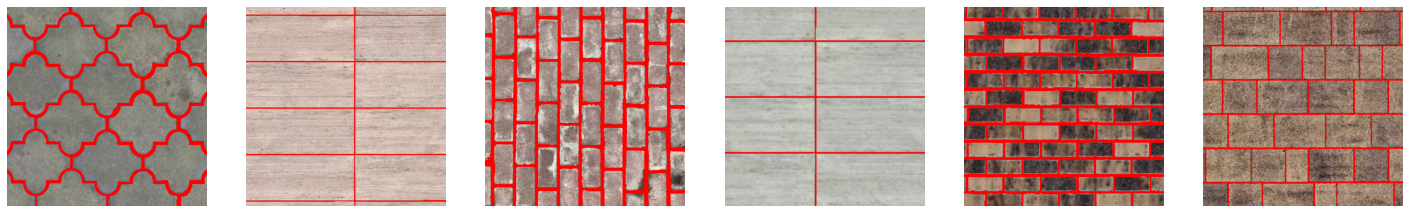

In [11]:
# Посмотрим несколько подготовленных картинок после предобработки и аугментации
# Швы из разметки выделим КРАСНЫМ цветом.
n = 6
g = generate_data(n)
images, anns = next(g)

fig, axs = plt.subplots(1, n, figsize=(25, 10))  

for i in range(n): 
  
  image = (images[i] * 255).astype(np.uint8)
  ann = u.ohe_to_mask(anns[i]) 
  
  ones = np.ones((ann.shape[0], ann.shape[1], 3),dtype = np.uint8)

  image[:, :, 0] = np.where(ann == 255, image[:, :, 0], ones[:, :, 0] * 255)
  image[:, :, 1] = np.where(ann == 255, image[:, :, 1], ones[:, :, 0] * 0)
  image[:, :, 2] = np.where(ann == 255, image[:, :, 2], ones[:, :, 0] * 0)

  
  axs[i].axis('off')
  axs[i].imshow(image)             

plt.show()   

### Unet

In [12]:
# Создаем модель
num_classes = len(classes)
modelUnet = unet.unet(num_classes, (img_height, img_width, 3))
# modelUnet.summary()
# plot_model(modelUnet, to_file="/content/modelUnet.png", show_shapes=True)

In [37]:
# Запускаем обучение
batch_size = 5
history = modelUnet.fit(generate_data(batch_size),steps_per_epoch= 100/batch_size, epochs=100)

Epoch 1/100
20/20 [==============================] - 25s 1s/step - loss: 0.4627 - dice_coef: 0.7519
Epoch 2/100
20/20 [==============================] - 23s 1s/step - loss: 0.2983 - dice_coef: 0.8463
Epoch 3/100
20/20 [==============================] - 22s 1s/step - loss: 0.3191 - dice_coef: 0.8198
Epoch 4/100
20/20 [==============================] - 23s 1s/step - loss: 0.2776 - dice_coef: 0.8305
Epoch 5/100
20/20 [==============================] - 23s 1s/step - loss: 0.2642 - dice_coef: 0.8448
Epoch 6/100
20/20 [==============================] - 23s 1s/step - loss: 0.2715 - dice_coef: 0.8469
Epoch 7/100
20/20 [==============================] - 23s 1s/step - loss: 0.2642 - dice_coef: 0.8455
Epoch 8/100
20/20 [==============================] - 23s 1s/step - loss: 0.2418 - dice_coef: 0.8506
Epoch 9/100
20/20 [==============================] - 23s 1s/step - loss: 0.2230 - dice_coef: 0.8685
Epoch 10/100
20/20 [==============================] - 23s 1s/step - loss: 0.2269 - dice_coef: 0.8681

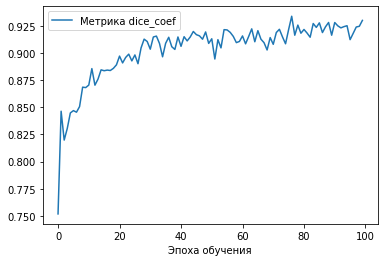

In [38]:
# График точности обучения
plt.plot(history.history['dice_coef'], label='Метрика dice_coef')
plt.xlabel('Эпоха обучения')
plt.legend()
plt.show()

In [49]:
# Сохраняем модель
model_file = os.path.join(PATH, '00-Unet')
modelUnet.save(model_file, save_format='tf')

model_file = os.path.join(PATH, '00-Unet.h5')
modelUnet.save(model_file)

!ls {PATH}

00-Unet  00-Unet.h5


### Предикт и визуализация

In [33]:
!ls {PATH}

00-Unet  00-Unet.h5


In [34]:
# Загружаем модель
model_file = os.path.join(PATH, '00-Unet')
model = load_model(model_file, custom_objects={'dice_coef':unet.dice_coef})

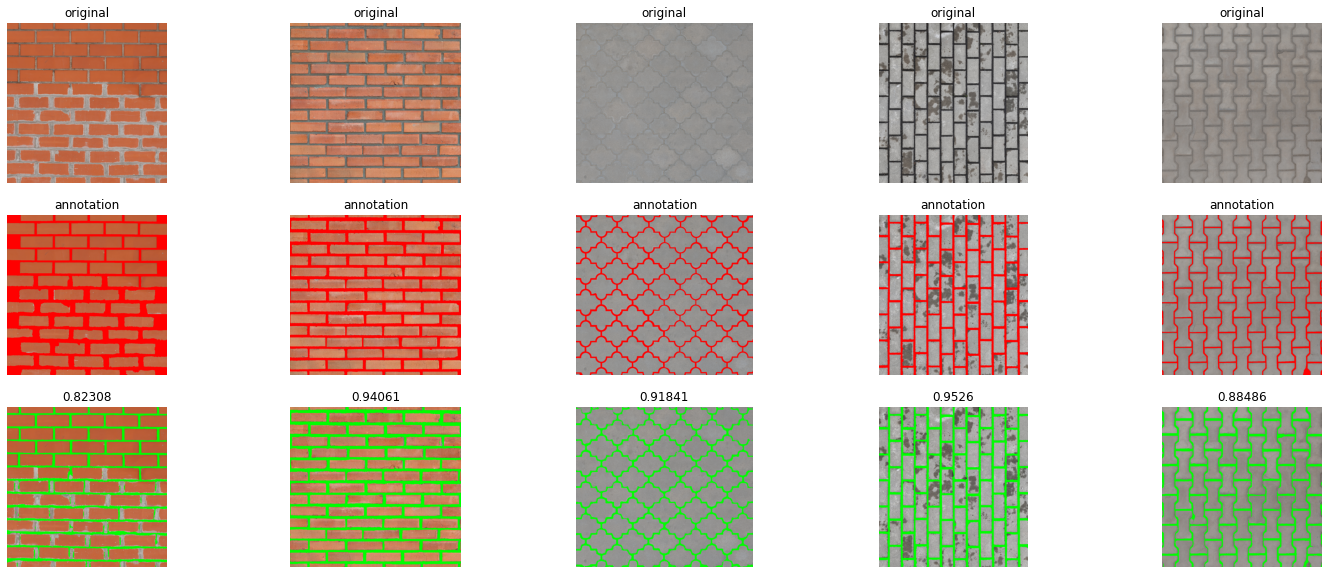

In [38]:
# Предикт и визуализация картинок из train
n = 5
fig, axs = plt.subplots(3, n, figsize=(25, 10))  

n_files = random.choices(img_names, k=n) 
for i,file in enumerate(n_files):
    image = cv.imread(file)
    image = cv.cvtColor(image, cv.COLOR_BGR2RGB)
    ann = cv.imread(os.path.join(anns_path, os.path.basename(file)), 0)
    pred= unet.pred_images(model, image, img_height, img_width)
    #
    ones = np.ones((ann.shape[0], ann.shape[1], 3),dtype = np.uint8)
    image_ann = image.copy()
    image_ann[:, :, 0] = np.where(ann == 255, image[:, :, 0], ones[:, :, 0] * 255)
    image_ann[:, :, 1] = np.where(ann == 255, image[:, :, 1], ones[:, :, 0] * 0)
    image_ann[:, :, 2] = np.where(ann == 255, image[:, :, 2], ones[:, :, 0] * 0)
    #
    ones = np.ones((pred.shape[0], pred.shape[1], 3),dtype = np.uint8)
    image_pred = image.copy()
    image_pred[:, :, 0] = np.where(pred == 255, image[:, :, 0], ones[:, :, 0] * 0)
    image_pred[:, :, 1] = np.where(pred == 255, image[:, :, 1], ones[:, :, 0] * 255)
    image_pred[:, :, 2] = np.where(pred == 255, image[:, :, 2], ones[:, :, 0] * 0)

    axs[0,i].axis('off')
    axs[0,i].imshow(image)
    axs[0,i].set_title('original')

    axs[1,i].axis('off')
    axs[1,i].imshow(image_ann)  
    axs[1,i].set_title('annotation')

    axs[2,i].axis('off')
    axs[2,i].imshow(image_pred)
    axs[2,i].set_title(round(unet.dice_coef_np(u.mask_to_ohe(ann), u.mask_to_ohe(pred)), 5))
    
plt.show()  

### Предикт на тестовых данных